# Cluster Experiments
After the data has been prepared (one entry per user with the userId and percentage of each genre he has watched) and transformed (pca, tsne) several clustering algorithms are tried (with hyper parameter tuning).  
The results of the clustering are ealuated visually based on plotting the transformed data and by manually having a look at the average percentage of watched genres in the different clusters.

In [1]:
# change used width of browser window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# import packages
import pandas as pd
import re
# import seaborn as sb
import matplotlib.pyplot as plt
# import datetime
# import json
# from sklearn.manifold import TSNE as TSNE
from sklearn.cluster import DBSCAN
# import KMeans
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [3]:
# pip install https://github.com/scikit-learn-contrib/scikit-learn-extra/archive/master.zip
from sklearn_extra.cluster import KMedoids

# 1. Load Data

In [4]:
df_joined = pd.read_csv("userclusterdata.csv")

In [5]:
df_tsne = pd.read_csv("tsne_allgenres.csv",header=None)
df_pca = pd.read_csv("pca_allgenres.csv",header=None)

# 2. Cluster Experiments
# 2.1 KMeans

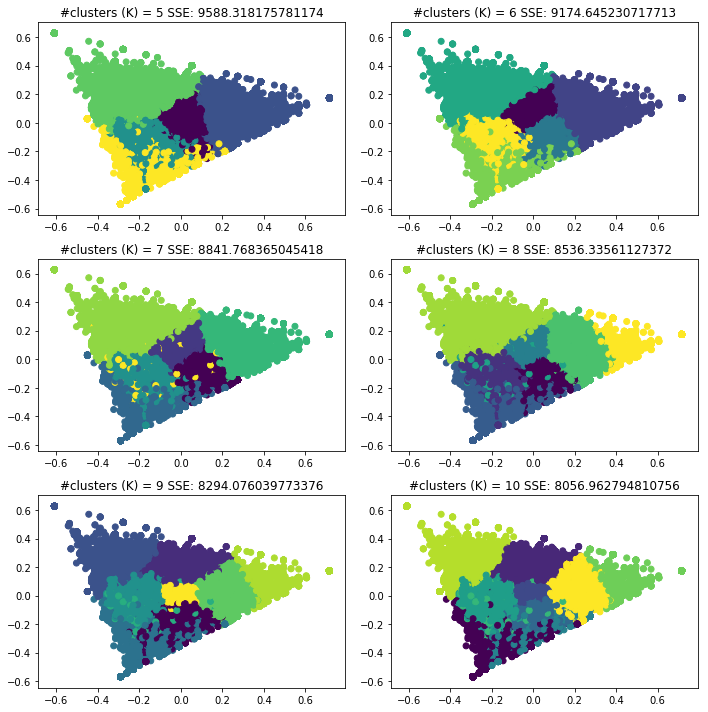

In [6]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
b = 2
for i in range(5,11):
    # create the clusterer
    estimator = KMeans(n_clusters = i)
    
    # create the clustering
#     cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId"))
    clusters = estimator.fit(df_joined.drop(columns="userId"))
    cluster_ids = estimator.predict(df_joined.drop(columns="userId"))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout()    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i) + " SSE: " + str(clusters.inertia_))
    # create the scatter plot
    plt.scatter(df_pca[0],df_pca[1], c=cluster_ids)

     # add a subplot
#     plt.subplot(6,2,b)
#     b = b + 2
#     # automatically adjust subplot params so that the subplot(s) fits in to the figure area
#     plt.tight_layout() 
#     # setup the labels of the subplot
#     plt.title("#clusters (K) = {}".format(i) + " SSE: " + str(clusters.inertia_))
#     # create the scatter plot
#     plt.scatter(df_tsne[0],df_tsne[1], c=cluster_ids)
        
plt.show()

Let's take a look at the genres in representative clusters:

In [7]:
# estimator = KMeans(n_clusters = 13)
# cluster_ids = estimator.fit_predict(df_tsne)
# df_joined["clusters"] = cluster_ids
# plt.scatter(df_tsne[0],df_tsne[1], c=cluster_ids) 
# plt.show()

In [8]:
# for cluster in range(0,13):
#     print("Cluster No " + str(cluster))
#     print("in this cluster: " + str(len(df_joined[df_joined["clusters"] == cluster])/len(df_joined)))
#     display(df_joined[df_joined["clusters"] == cluster].drop(columns=["userId", "clusters"]).describe())

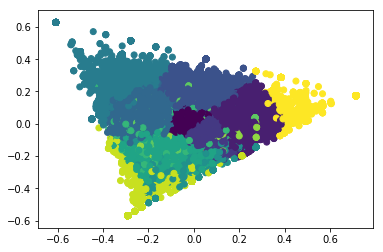

In [14]:
estimator = KMeans(n_clusters = 13)
cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId"))
df_joined["clusters"] = cluster_ids
plt.scatter(df_pca[0],df_pca[1], c=cluster_ids) 
plt.show()

In [10]:
for cluster in range(0,13):
    print("Cluster No " + str(cluster))
    print("in this cluster: " + str(len(df_joined[df_joined["clusters"] == cluster])/len(df_joined)))
    display(df_joined[df_joined["clusters"] == cluster].drop(columns=["userId", "clusters"]).describe())

Cluster No 0
in this cluster: 0.02343300477234522


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000,6231.000000
mean,0.276589,0.027417,0.013527,0.019847,0.012749,0.004013,0.050444,0.012195,0.054348,0.278672,0.006216,0.034482,0.017125,0.012163,0.006574,0.018114,0.097226,0.014630,0.042707,0.000962
std,0.096210,0.053752,0.037152,0.053464,0.035141,0.020898,0.073831,0.037715,0.086197,0.115966,0.027073,0.053035,0.042810,0.038110,0.034027,0.047739,0.095563,0.035919,0.084847,0.010867
min,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.208333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225926,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085088,0.000000,0.000000,0.000000
75%,0.333333,0.041667,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.333333,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.050000,0.000000
max,1.000000,0.500000,0.333333,0.500000,0.333333,0.444444,0.333333,0.333333,0.416667,0.511905,0.250000,0.333333,0.500000,0.333333,0.500000,0.500000,0.375000,0.333333,0.500000,0.250000


Cluster No 1
in this cluster: 0.3892112655928577


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000,103494.000000
mean,0.076478,0.049039,0.051137,0.015084,0.027595,0.010945,0.087172,0.010576,0.035796,0.266316,0.036822,0.053273,0.024783,0.010941,0.007072,0.033300,0.168612,0.020818,0.013652,0.000591
std,0.028836,0.026489,0.029204,0.017087,0.020090,0.013473,0.030856,0.013504,0.021832,0.032888,0.033412,0.025932,0.019432,0.013664,0.014441,0.023015,0.028999,0.018629,0.015025,0.003018
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113636,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000
25%,0.060983,0.036717,0.034749,0.000000,0.016667,0.000000,0.072188,0.000000,0.022981,0.246910,0.012097,0.040711,0.014706,0.001143,0.000000,0.020833,0.149674,0.009524,0.003401,0.000000
50%,0.076400,0.047222,0.051990,0.013072,0.026499,0.008737,0.086487,0.008786,0.033367,0.266874,0.031690,0.053333,0.023551,0.008155,0.000000,0.029680,0.166667,0.019608,0.010929,0.000000
75%,0.090728,0.058333,0.066667,0.020325,0.035897,0.016000,0.102564,0.014493,0.045238,0.286905,0.051282,0.064198,0.031428,0.014719,0.009981,0.041667,0.185209,0.027778,0.017544,0.000000
max,0.226190,0.500000,0.250000,0.375000,0.400000,0.500000,0.285714,0.333333,0.416667,0.378788,0.200000,0.277778,0.375000,0.277778,0.500000,0.416667,0.300000,0.375000,0.277778,0.250000


Cluster No 2
in this cluster: 0.0679260042044775


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000,18062.000000
mean,0.065670,0.049160,0.152567,0.018500,0.042100,0.016996,0.104537,0.010466,0.051227,0.178241,0.018315,0.063362,0.038170,0.011353,0.009096,0.032707,0.091179,0.025153,0.014664,0.000446
std,0.052298,0.065191,0.083202,0.040265,0.061296,0.050512,0.063699,0.026582,0.057271,0.072659,0.039014,0.057244,0.062823,0.025421,0.047907,0.041693,0.060894,0.047424,0.029506,0.005591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.023810,0.000000,0.100000,0.000000,0.000000,0.000000,0.064559,0.000000,0.000000,0.142857,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000
50%,0.064286,0.041667,0.142857,0.000000,0.030303,0.000000,0.105556,0.000000,0.041667,0.190476,0.000000,0.055556,0.021053,0.000000,0.000000,0.023810,0.095238,0.000000,0.000000,0.000000
75%,0.097222,0.069444,0.200000,0.023810,0.062500,0.023810,0.145503,0.005714,0.072078,0.226190,0.000000,0.088542,0.050000,0.009524,0.000000,0.050926,0.131860,0.034483,0.018519,0.000000
max,0.333333,1.000000,0.400000,1.000000,1.000000,1.000000,0.333333,0.416667,1.000000,0.400000,0.250000,0.416667,1.000000,0.277778,1.000000,0.500000,0.333333,0.500000,0.333333,0.333333


Cluster No 3
in this cluster: 0.012474286122591733


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000,3317.000000
mean,0.092408,0.026574,0.026336,0.016698,0.013592,0.004272,0.027117,0.004360,0.014048,0.087061,0.007215,0.031085,0.015285,0.008600,0.004198,0.013839,0.577994,0.023106,0.005850,0.000363
std,0.146871,0.072651,0.077112,0.065922,0.052343,0.022335,0.058039,0.021989,0.038188,0.095433,0.038001,0.073172,0.051112,0.043733,0.029600,0.047742,0.177191,0.069927,0.030366,0.005054
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.388889,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.166667,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.000000
max,0.500000,0.500000,0.500000,0.500000,0.500000,0.250000,0.500000,0.250000,0.500000,0.375000,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,1.000000,0.500000,0.500000,0.125000


Cluster No 4
in this cluster: 0.008608272817187965


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000,2289.000000
mean,0.026668,0.013166,0.005378,0.005877,0.002846,0.000508,0.020664,0.004740,0.004672,0.822152,0.001606,0.026550,0.005093,0.004069,0.001213,0.005317,0.041034,0.004573,0.003681,0.000194
std,0.063711,0.046948,0.030736,0.030459,0.018994,0.007174,0.056218,0.027035,0.023812,0.147515,0.017921,0.065082,0.027340,0.024769,0.013357,0.027643,0.081082,0.024882,0.021127,0.005444
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.333333,0.333333,0.333333,0.250000,0.250000,0.166667,0.333333,0.250000,0.250000,1.000000,0.333333,0.250000,0.333333,0.250000,0.250000,0.250000,0.333333,0.250000,0.166667,0.166667


Cluster No 5
in this cluster: 0.02137213386635177


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000,5683.000000
mean,0.051270,0.042112,0.027661,0.015489,0.019024,0.005465,0.059638,0.008408,0.033143,0.191560,0.286097,0.036412,0.022690,0.012895,0.006292,0.045056,0.102750,0.012336,0.021366,0.000337
std,0.057565,0.056847,0.054978,0.046744,0.037697,0.024371,0.062813,0.030503,0.043252,0.104721,0.166867,0.054173,0.040299,0.043394,0.031428,0.069017,0.087250,0.032128,0.035833,0.005259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128333,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.040000,0.025000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,0.000000,0.200000,0.250000,0.000000,0.000000,0.000000,0.000000,0.017544,0.100000,0.000000,0.000000,0.000000
75%,0.083333,0.066667,0.031250,0.000000,0.033333,0.000000,0.100000,0.000000,0.060606,0.250000,0.333333,0.065738,0.037037,0.000000,0.000000,0.071429,0.166667,0.000000,0.041667,0.000000
max,0.333333,0.500000,0.333333,0.500000,0.500000,0.500000,0.500000,0.500000,0.333333,0.500000,1.000000,0.333333,0.500000,0.500000,0.333333,0.500000,0.500000,0.312500,0.500000,0.166667


Cluster No 6
in this cluster: 0.22256653642062826


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000,59182.000000
mean,0.078756,0.051099,0.068362,0.013792,0.033896,0.012682,0.108474,0.010021,0.037346,0.308533,0.020316,0.054743,0.022753,0.009695,0.004815,0.034983,0.102028,0.015485,0.011842,0.000378
std,0.034400,0.034058,0.042829,0.020471,0.028986,0.017324,0.039383,0.017314,0.027466,0.037332,0.030869,0.030972,0.025208,0.015700,0.016195,0.028068,0.037086,0.019287,0.017708,0.003203
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.059259,0.033333,0.041667,0.000000,0.014706,0.000000,0.085556,0.000000,0.020370,0.281760,0.000000,0.037037,0.000000,0.000000,0.000000,0.018058,0.083333,0.000000,0.000000,0.000000
50%,0.078965,0.048965,0.065393,0.008808,0.030769,0.007576,0.105825,0.004000,0.034667,0.307848,0.000000,0.052381,0.020000,0.004926,0.000000,0.032828,0.108631,0.012121,0.006667,0.000000
75%,0.098214,0.063953,0.090909,0.019753,0.047619,0.020833,0.128639,0.014103,0.050765,0.333333,0.032787,0.068182,0.031667,0.012363,0.000000,0.047222,0.127449,0.022727,0.017094,0.000000
max,0.250000,0.750000,0.333333,0.500000,0.500000,0.500000,0.306667,0.333333,0.333333,0.433333,0.200000,0.238095,0.500000,0.333333,0.500000,0.500000,0.214286,0.333333,0.333333,0.166667


Cluster No 7
in this cluster: 0.007844848010770683


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000,2086.000000
mean,0.023372,0.014641,0.563241,0.005671,0.016445,0.001933,0.151902,0.002833,0.016127,0.109334,0.006830,0.018907,0.016686,0.004992,0.001481,0.009190,0.023845,0.004990,0.007502,0.000080
std,0.059745,0.054433,0.197162,0.033104,0.066457,0.016546,0.169826,0.018731,0.055541,0.127835,0.049276,0.051016,0.067902,0.026170,0.018256,0.038657,0.063626,0.027225,0.031991,0.002580
min,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.500000,1.000000,0.500000,0.500000,0.250000,0.500000,0.250000,0.500000,0.500000,0.500000,0.500000,0.500000,0.250000,0.500000,0.500000,0.444444,0.250000,0.333333,0.083333


Cluster No 8
in this cluster: 0.01597927094811344


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000,4249.000000
mean,0.034819,0.055649,0.045640,0.008069,0.021887,0.003574,0.336613,0.005738,0.017760,0.222306,0.006144,0.067465,0.009867,0.008216,0.003484,0.108316,0.031671,0.005828,0.006668,0.000287
std,0.056710,0.091593,0.078123,0.031511,0.059034,0.021135,0.114459,0.029025,0.044970,0.144369,0.029323,0.101356,0.032889,0.029743,0.028802,0.146112,0.056307,0.023813,0.029342,0.005925
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.312500,0.000000,0.000000,0.238095,0.000000,0.000000,0.000000,0.000000,0.000000,0.053571,0.000000,0.000000,0.000000,0.000000
75%,0.066667,0.083333,0.076190,0.000000,0.000000,0.000000,0.416667,0.000000,0.000000,0.333333,0.000000,0.111111,0.000000,0.000000,0.000000,0.166667,0.055556,0.000000,0.000000,0.000000
max,0.500000,0.500000,0.333333,0.500000,0.500000,0.500000,1.000000,0.500000,0.333333,0.500000,0.333333,0.500000,0.333333,0.333333,0.500000,1.000000,0.333333,0.250000,0.500000,0.250000


Cluster No 9
in this cluster: 0.00924383337031368


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000
mean,0.036781,0.020651,0.005270,0.006011,0.009868,0.003017,0.041353,0.008729,0.049021,0.354874,0.001427,0.343633,0.016662,0.030916,0.018345,0.005389,0.015387,0.007127,0.025466,0.000071
std,0.066484,0.064062,0.025541,0.029493,0.041824,0.027388,0.076663,0.040813,0.090802,0.138893,0.015675,0.119882,0.062113,0.081361,0.074191,0.025746,0.041638,0.033698,0.062468,0.002047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.309028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.083333,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.333333,0.500000,0.333333,0.333333,0.500000,0.500000,0.333333,0.333333,0.500000,0.583333,0.333333,1.000000,0.500000,0.500000,0.500000,0.250000,0.250000,0.333333,0.500000,0.062500


Cluster No 10
in this cluster: 0.08361193951268676


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000,22233.000000
mean,0.070944,0.048439,0.030835,0.017198,0.017069,0.006278,0.077221,0.012715,0.026291,0.446954,0.018351,0.047421,0.017363,0.011438,0.004536,0.026626,0.090374,0.013723,0.015811,0.000413
std,0.054951,0.071412,0.050073,0.047120,0.030609,0.019894,0.061816,0.037493,0.037637,0.060380,0.042315,0.045303,0.038794,0.030292,0.021833,0.042297,0.059796,0.034165,0.037407,0.005013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250,0.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000
50%,0.068182,0.031250,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.013158,0.433333,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.098485,0.000000,0.000000,0.000000
75%,0.108333,0.066667,0.049008,0.014493,0.027778,0.000000,0.111111,0.004808,0.041667,0.500000,0.000000,0.074074,0.024691,0.010204,0.000000,0.041667,0.135417,0.015152,0.020833,0.000000
max,0.333333,0.666667,0.400000,0.500000,0.500000,0.500000,0.333333,0.500000,0.500000,0.642857,0.400000,0.250000,0.500000,0.500000,0.500000,0.500000,0.277778,0.500000,0.500000,0.250000


Cluster No 11
in this cluster: 0.0732925421293911


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000,19489.000000
mean,0.078668,0.050211,0.044263,0.020200,0.027807,0.010810,0.069683,0.010477,0.043213,0.155364,0.024135,0.064967,0.032775,0.011855,0.008593,0.032304,0.264374,0.037444,0.012212,0.000646
std,0.061290,0.057290,0.054637,0.038963,0.044688,0.029263,0.056870,0.023599,0.048332,0.063827,0.044690,0.058410,0.049110,0.027016,0.031105,0.044423,0.063361,0.051472,0.024570,0.006214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000
25%,0.035714,0.000000,0.000000,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.123810,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.220000,0.000000,0.000000,0.000000
50%,0.071429,0.038462,0.030303,0.000000,0.000000,0.000000,0.064815,0.000000,0.033333,0.166667,0.000000,0.055556,0.019048,0.000000,0.000000,0.020000,0.256463,0.023810,0.000000,0.000000
75%,0.111111,0.072917,0.071429,0.030864,0.041667,0.000000,0.100794,0.008065,0.064286,0.202381,0.035714,0.091111,0.047619,0.011905,0.000000,0.050000,0.306667,0.055556,0.017544,0.000000
max,0.375000,0.555556,0.375000,0.666667,0.500000,0.500000,0.416667,0.500000,0.333333,0.266667,0.285714,0.444444,0.500000,0.444444,0.500000,0.416667,0.450000,0.666667,0.266667,0.333333


Cluster No 12
in this cluster: 0.06443606223228422


,Romance,Crime,Horror,Music,Science Fiction,Animation,Thriller,History,Adventure,Drama,Documentary,Action,Fantasy,Foreign,Western,Mystery,Comedy,Family,War,TV Movie
count,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000,17134.000000
mean,0.065053,0.035451,0.021282,0.013344,0.013009,0.005061,0.047168,0.008363,0.021584,0.356404,0.017692,0.038826,0.016582,0.009209,0.004093,0.024904,0.271892,0.017860,0.011673,0.000551
std,0.053410,0.042157,0.037144,0.033238,0.024634,0.016516,0.045985,0.020576,0.028479,0.066612,0.037909,0.044896,0.028701,0.021435,0.020610,0.034548,0.075152,0.033019,0.022812,0.005269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154762,0.000000,0.000000,0.000000
25%,0.022689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.307823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.218889,0.000000,0.000000,0.000000
50%,0.060606,0.027304,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.009804,0.347222,0.000000,0.031250,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000
75%,0.097222,0.055556,0.033333,0.013158,0.020833,0.000000,0.075490,0.000000,0.037037,0.391667,0.000000,0.060606,0.027778,0.007519,0.000000,0.041667,0.303030,0.027778,0.017544,0.000000
max,0.291667,0.333333,0.333333,0.500000,0.333333,0.333333,0.333333,0.333333,0.333333,0.638889,0.250000,0.333333,0.333333,0.333333,0.500000,0.250000,0.500000,0.333333,0.333333,0.166667


# 2.2 KMedoids
Unable to run KMedoids on all data. BUT  
- we don't have real outliers anyways  
- the clusters with a sample of 10.000 of the data don't look too different from KMeans with all data  
-> KMeans is the better choice

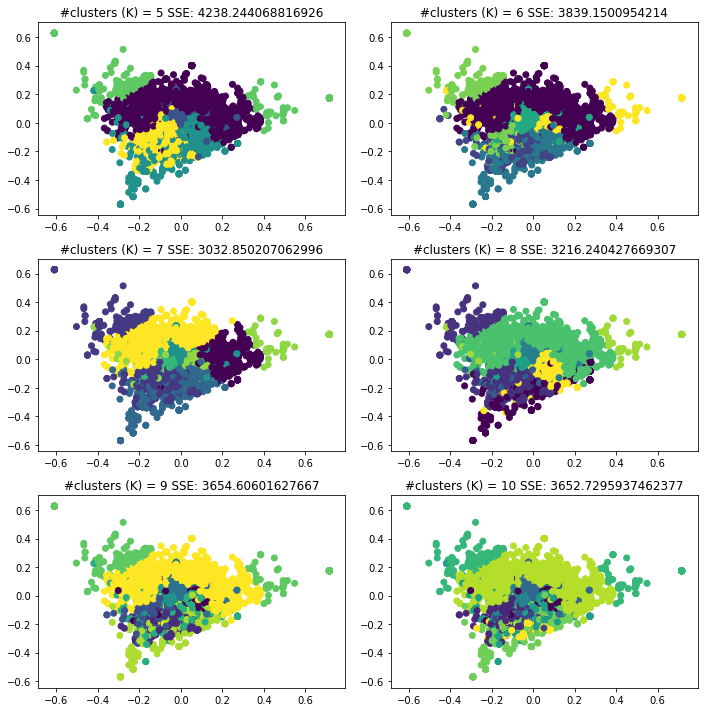

In [11]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(5,11):
    # create the clusterer
    estimator = KMedoids(metric="euclidean", n_clusters=i)
    
    # create the clustering
#     cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId"))
    clusters = estimator.fit(df_joined.drop(columns="userId").head(10000))
    cluster_ids = estimator.predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i) + " SSE: " + str(clusters.inertia_))
#     plt.xlabel('ItemsBought')
#     plt.ylabel('ItemsReturned')
    
    # create the scatter plot
    plt.scatter(df_pca.head(10000)[0],df_pca.head(10000)[1], c=cluster_ids)
#     plt.scatter(df_tsne[0],df_tsne[1], c=cluster_ids)
        
plt.show()

# 2.3 Agglomerative Clustering
unable to run with all data, but it doesn't work well with linkage=single anyways.  
works well with linkage=ward, BUT since its not possible to run it on all data and the difference to kmeans doesn't appear to be very large we prefer kmeans

In [ ]:
# setup a figure
plt.figure(figsize=(10,10))

# iterate over all values that we want to test for K
a = 1
for i in range(5,11):
    # create the clusterer
    estimator = AgglomerativeClustering(n_clusters = i, linkage='ward', affinity='euclidean')
    
    # create the clustering
#     cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId"))
#     clusters = estimator.fit(df_tsne)
    cluster_ids = estimator.fit_predict(df_joined.drop(columns="userId").head(10000))

    # add a subplot
    plt.subplot(3,2,a)
    a = a + 1
    
    # automatically adjust subplot params so that the subplot(s) fits in to the figure area
    plt.tight_layout() 
    
    # setup the labels of the subplot
    plt.title("#clusters (K) = {}".format(i))
#     plt.xlabel('ItemsBought')
#     plt.ylabel('ItemsReturned')
    
    # create the scatter plot
    plt.scatter(df_pca[0].head(10000),df_pca[1].head(10000), c=cluster_ids)
#     plt.scatter(df_tsne.head(10000)[0],df_tsne.head(10000)[1], c=cluster_ids)
        
plt.show()

## 2.4 DBSCAN
doesn't work well on a subset of the data, unable to run on all data

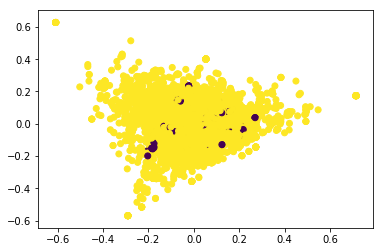

In [13]:
# create the clusterer
clusterer = DBSCAN(min_samples=25, eps=0.02, metric='cosine')
# create the clusters
clusters = clusterer.fit(df_joined.drop(columns="userId").head(10000))

plt.scatter(df_pca.head(10000)[0],df_pca.head(10000)[1] ,c=clusters.labels_)
plt.show()

# 3. Add Cluster IDs to Ratings
The cluster IDs can then be used to calculate the average rating of a cluster per movie.  
These ratings are calculated for the whole movie dataset, then the training part of the dataset is used to train a model per cluster (clusterrating as target variable) and the test part to evaluate these models.

In [17]:
# load ratings
df_ratings = pd.read_csv("the-movies-dataset/ratings.csv")

In [16]:
# add cluster ID to ratings.csv
# df_ratings[df_ratings["userId"] == df_joined["userId"]]

In [ ]:
# calculate average cluster ratings for movies